### Axion Receiver Chain: Beyond the Bode Fano Bound

The load and equivalent circuit representation of a basic resonant lumped element search can be phrased in terms of a classical Bode-Fano problem:

**Theorem:** The maximum power extracted in a classical matching network between a real impedance source and a complex impedance load is bounded by the Bode-Fano integral. 

In the context of the below representation of a DMRadio-style resonant search, given a fixed voltage, resistance, and $L_p$ (i.e. a fixed axion source with a complex impedance), this is equivalent to maximizing the power delivered to the load (i.e. the power across $R_L$).

<img src="images/axion_load_model.png" alt="Axion receiver model" width="500"/>

Now, there are several important deviations from the classically defined Bode-Fano limits: for one, Bode-Fano developed their equations by matching a real source impedance to a complex load. This is not identical to the DMRadio situation, where we prefer to frame the source as having a reactive component due to our inductive pickup. 

As such, we must first derive limits to the Bode-Fano integral in the *dual representation*. 

#### Derivation of the Bode-Fano Bound 

Let us consider the axion receiver model defined above. A reasonable figure of merit is the ratio of actual load power $P_L$ divided by the maximum power delivered by the axion, $P_a$. A convenient metric is then the *reflection coefficient* of rejected power: 

$$ |\rho|^2 = 1 - \dfrac{P_L}{P_a} $$

This can also be defined as 

$$\rho = \dfrac{Z - 1}{Z + 1}$$ 

where Z is the impedance *as seen by the axion*. In other words, this reflection coefficient considers the effect of screening current within the axion pickup loop. 

The Bode-Fano problem can be stated as follows: Can we design a matching network where the input reflection coefficient, $\rho$ is smaller than or equal to a specified $\rho_{max}$ across a frequency band?

## Numerical Demonstration of the Bode Fano bound

Let us start with a numerical demonstration of the Bode-Fano bound for a simple LC matching network. This is a well-solved matching archiecture, better known as an *L-network*.

<img src="images/LC.png" alt="Axion receiver model" width="500"/>

We start by calculating $Z_{in}$, the input impedance at the input port:

$$ Z_{in} = j\omega L + \dfrac{1}{\frac{1}{R_L} - j\omega C} = j\omega L + \dfrac{R_L}{1 - j\omega C R_L} $$ 
$$ Z_{in} = j\omega L + \dfrac{R_L(1+j\omega C R_L)}{1+\omega^2 C^2 R_L^2} = \dfrac{R_L}{1+\omega^2 C^2 R_L^2} + j\left(\omega L - \dfrac{\omega C R_L^2}{1+\omega^2 C^2 R_L^2}\right) $$

For an optimal match, we want to match $R_s = R_L$ and cancel the reactive components of the above expression. This creates two constraints:

$$ R_s = \dfrac{R_L}{1+\omega^2 C^2 R_L^2}$$

and 

$$ \omega L - \dfrac{\omega C R_L^2}{1+\omega^2 C^2 R_L^2} = 0$$

Now, let us ask ourselves the question: for a given $R_S$, $R_L$ at a fixed frequency $\omega$, what does this constrain the values of $L$ and $C$ to be?

In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging, importlib

logging.basicConfig(level=logging.WARNING)

In [3]:
### Plug in values
Rs = 100 
Rl = 1700
omega = 2 * np.pi * 9 * 10**8 #MHz

In [4]:
C = 1/(omega * Rl) * np.sqrt(Rl/Rs - 1)
print(f'Matched capacitor: {C}')

L = C * Rl**2 * (Rs/Rl)
print(f'Matched inductor: {L}')

Matched capacitor: 4.1609135448861524e-13
Matched inductor: 7.073553026306459e-08


## Validating via SPICE Simulation

In [5]:
from pyWRspice import simulation
engine = simulation.WRWrapper(command = "/usr/local/xictools/bin/wrspice") # Typical for Unix

In [6]:
resistance = """* Pure matched resistances

v1 0 1 AC 10 SIN(0 10 900e6)

r1 1 2 100    
r2 2 0 100

.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} v(1)-v(0) i(v1) v(1)-v(2) v(2)-v(0) 
.endc
"""

params = {'tran_step': 1e-10, 'tran_stop': 1e-8, 'tran_start': 3e-9, 'maxdata': 1024000, 'output_file': None} 
dat = engine.run(resistance, save_file=False, **params)

# Extract the data
dat = dat.to_array()
ts = dat[0]
v2 = dat[1]
v3 = dat[3]
v4 = dat[4] 
v5 = dat[2] 

print(f'RMS power in Rs: {np.average((v3**2/100))}')
print(f'RMS power in Rl: {np.average((v4**2/100))}')

print(f'RMS power pulled from voltage source: {np.average(v5 * v2)}')
print(f'RMS power pulled from voltage source: {np.average(v2**2*200)}')

RMS power in Rs: 0.12436181517940731
RMS power in Rl: 0.12436181517940731
RMS power pulled from voltage source: 0.24872363035881462
RMS power pulled from voltage source: 0.2487236303588147


In [8]:
resistance = """* Pure resistances, unmatched

v1 0 1 AC 10 SIN(0 10 900e6)

r1 1 2 100    
r2 2 0 1700

.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} v(1)-v(0) i(v1) v(1)-v(2) v(2)-v(0) 
.endc
"""

params = {'tran_step': 1e-10, 'tran_stop': 1e-8, 'tran_start': 3e-9, 'maxdata': 1024000, 'output_file': None} 
dat = engine.run(resistance, save_file=False, **params)

# Extract the data
dat = dat.to_array()
ts = dat[0]
v2 = dat[1]
v3 = dat[3]
v4 = dat[4] 
v5 = dat[2] 

print(f'RMS power in Rs: {np.average((v3**2/100))}')
print(f'RMS power in Rl: {np.average((v4**2/1700))}')

print(f'RMS power pulled from voltage source: {np.average(v5 * v2)}')

RMS power in Rs: 0.001535331051597613
RMS power in Rl: 0.02610062787715956
RMS power pulled from voltage source: 0.0276359589287571


#### Notice that when Rs and Rl are not matched, we see that the total power drawn from the circuit is smaller (and so is the power dissipated in the load)

In [9]:
LC = """* Basic LC matching network

v1 0 1 AC 10 SIN(0 10 {freq})

r1 1 2 100  
l1 2 3 {l_mag}     
c1 3 0 {c_mag}  
r2 3 0 1700

.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} v(1)-v(0) i(v1) v(1)-v(2) v(3)-v(0) 
.endc
"""

params = {'freq': 900e6, 'l_mag': L, 'c_mag': C, 'tran_step': 1e-10, 'tran_stop': 1e-8, 'tran_start': 3e-9, 'maxdata': 1024000, 'output_file': None} 
dat = engine.run(LC, save_file=False, **params)

# Extract the data
dat = dat.to_array()
ts = dat[0]
v2 = dat[1]
v3 = dat[3]
v4 = dat[4] 
v5 = dat[2] 

print(f'RMS power in Rs: {np.average((v3**2/100))}')
print(f'RMS power in Rl: {np.average((v4**2/1700))}')

print(f'RMS power pulled from voltage source: {np.average(v5 * v2)}')

p_load_flat = np.average((v4**2/1700))
p_flat = np.average(v5 * v2)

RMS power in Rs: 0.12049789024937836
RMS power in Rl: 0.11366476903433201
RMS power pulled from voltage source: 0.23547341546638298


#### Now, we've added an LC matching network and significantly increased both the power pulled from the source, as well as the power read out on the load

#### Now lets do a sweep over the input frequency for the parallel matching network and see how the power extracted changes off resonance

In [16]:
### Run parallel sweep
LC = """* LC 

v1 0 1 AC 10 SIN(0 10 {freq})

r1 1 2 100  
l1 2 3 {l_mag}     
c1 3 0 {c_mag}  
r2 3 0 1700

.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} v(1)-v(0) i(v1) v(1)-v(2) v(3)-v(0) 
.endc
"""

params = {'freq': 900e6, 'l_mag': L, 'c_mag': C, 'tran_step': 1e-10, 'tran_stop': 1e-8, 'tran_start': 3e-9, 'maxdata': 1024000, 'output_file': None} 
dat = engine.run(LC, save_file=False, **params)

params["freq"] = np.geomspace(1e7, 1e10, 500)
params, dat = engine.run_parallel(LC, save_file=False, **params)

['python', 'data/run_parallel.py', '/var/folders/xj/352c_sbx4t992f2lk29vd9cm0000gn/T/tmp5yxx_41z/simconfig_20250803_172246.csv', '--processes=5']
['simulation.py', 'waveforms.py', '.DS_Store', 'josephson1.jpg', 'remote.py', 'josephson_oscillation.jpg', 'IV_coupled_flux.jpg', '__init__.py', '__pycache__', 'IV.jpg', 'parse.py', 'script.py', 'data', 'proposal_IV_coupled_flux.pdf', 'proposal_IV_coupled_flux.png', 'proposal_IV_coupled_flux.jpg']


In [17]:
PL = []
Pin = []

for d in dat:
    d = d.to_array()
    ts = d[0]
    v2 = d[1]
    v3 = d[3]
    v4 = d[4] 
    v5 = d[2] 

    PL.append(np.average((v4**2/1700)))
    Pin.append(np.average(v5 * v2))
    
PL = np.array(PL)
Pin = np.array(Pin)

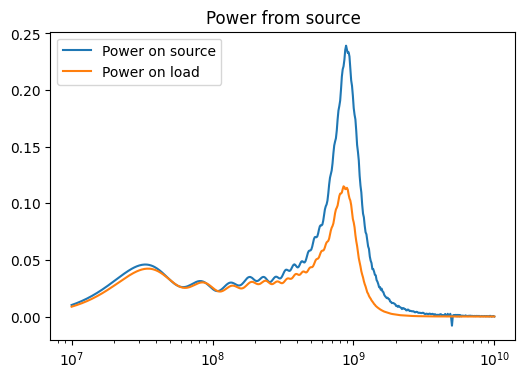

In [18]:
plt.figure(figsize=(6,4))

plt.title('Power from source')
plt.plot(np.geomspace(1e7, 1e10, 500), Pin, label='Power on source')
plt.plot(np.geomspace(1e7, 1e10, 500), PL, label='Power on load')

plt.xscale('log')
# plt.yscale('log')

plt.legend()

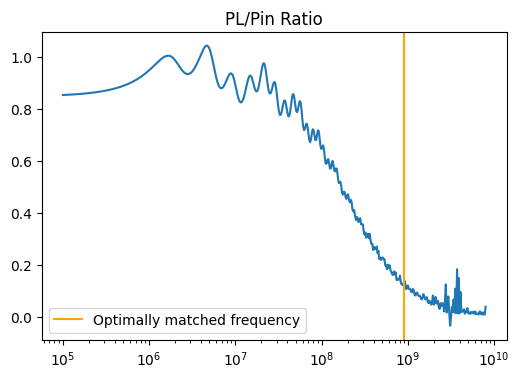

In [24]:
plt.figure(figsize=(6,4))

plt.title('PL/Pin Ratio')
plt.plot(np.geomspace(1e5, 1e10, 500)[:-10], np.array(PL/Pin)[:-10])

plt.axvline(900e6, label='Optimally matched frequency', color='orange')

plt.xscale('log')
plt.legend()

In [30]:
#### Now consider the series circuit topology instead. We expect that, in the case where Q>1, the circuit impedance goes to infinity at the optimal matching point

In [31]:
LL = """* LC series

v1 0 1 AC 10 SIN(0 10 {freq})

r1 1 2 100  
l1 2 3 0     
c1 3 4 {c_mag} 
r2 4 0 1700

.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} v(1)-v(0) i(v1) v(1)-v(2) v(4)-v(0) 
.endc
"""

params = {'freq': 900e6, 'l_mag': L, 'c_mag': C, 'tran_step': 1e-10, 'tran_stop': 1e-8, 'tran_start': 3e-9, 'maxdata': 1024000, 'output_file': None} 

params["freq"] = np.geomspace(1e5, 1e10, 500)
params, dat = engine.run_parallel(LL, save_file=False, **params)

['python', 'data/run_parallel.py', '/var/folders/xj/352c_sbx4t992f2lk29vd9cm0000gn/T/tmp5yxx_41z/simconfig_20250803_172738.csv', '--processes=5']
['simulation.py', 'waveforms.py', '.DS_Store', 'josephson1.jpg', 'remote.py', 'josephson_oscillation.jpg', 'IV_coupled_flux.jpg', '__init__.py', '__pycache__', 'IV.jpg', 'parse.py', 'script.py', 'data', 'proposal_IV_coupled_flux.pdf', 'proposal_IV_coupled_flux.png', 'proposal_IV_coupled_flux.jpg']


In [32]:
PL = []
Pin = []

for d in dat:
    d = d.to_array()
    ts = d[0]
    v2 = d[1]
    v3 = d[3]
    v4 = d[4] 
    v5 = d[2] 

    PL.append(np.average((v4**2/1700)))
    Pin.append(np.average(v5 * v2))
    
PL = np.array(PL)
Pin = np.array(Pin)

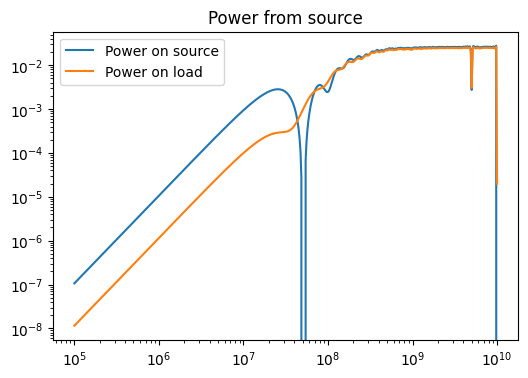

In [33]:
plt.figure(figsize=(6,4))

plt.title('Power from source')
plt.plot(np.geomspace(1e5, 1e10, 500), Pin, label='Power on source')
plt.plot(np.geomspace(1e5, 1e10, 500), PL, label='Power on load')

plt.xscale('log')
plt.yscale('log')

plt.legend()

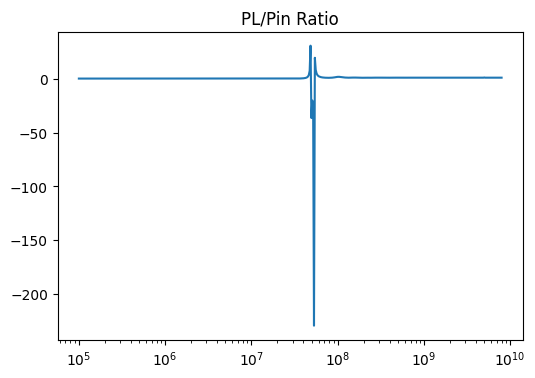

In [34]:
plt.figure(figsize=(6,4))

plt.title('PL/Pin Ratio')
plt.plot(np.geomspace(1e5, 1e10, 500)[:-10], np.array(PL/Pin)[:-10])

plt.xscale('log')

### Now lets try a topology where the L and the C are in parallel: so a fully parallel RLC circuit. What does the power look like here?

In [39]:
LL = """* LL

v1 0 1 AC 10 SIN(0 10 {freq})

r1 1 2 100    
l2 2 0 {l_mag}  
c1 2 0 {c_mag} 
r2 2 0 1700

.tran {tran_step} {tran_stop} {tran_start} uic 
.control
set maxdata={maxdata}
run
set filetype=binary
write {output_file} v(1)-v(0) i(v1) v(1)-v(2) v(2)-v(0) 
.endc
"""

params = {'freq': 900e6, 'l_mag': L, 'c_mag': C, 'tran_step': 1e-10, 'tran_stop': 1e-8, 'tran_start': 3e-9, 'maxdata': 1024000, 'output_file': None} 

params["freq"] = np.geomspace(1e5, 1e12, 500)
params, dat = engine.run_parallel(LL, save_file=False, **params)

['python', 'data/run_parallel.py', '/var/folders/xj/352c_sbx4t992f2lk29vd9cm0000gn/T/tmp5yxx_41z/simconfig_20250803_172950.csv', '--processes=5']
['simulation.py', 'waveforms.py', '.DS_Store', 'josephson1.jpg', 'remote.py', 'josephson_oscillation.jpg', 'IV_coupled_flux.jpg', '__init__.py', '__pycache__', 'IV.jpg', 'parse.py', 'script.py', 'data', 'proposal_IV_coupled_flux.pdf', 'proposal_IV_coupled_flux.png', 'proposal_IV_coupled_flux.jpg']


In [40]:
PL = []
Pin = []

for d in dat:
    d = d.to_array()
    ts = d[0]
    v2 = d[1]
    v3 = d[3]
    v4 = d[4] 
    v5 = d[2] 

    PL.append(np.average((v4**2/1700)))
    Pin.append(np.average(v5 * v2))
    
PL = np.array(PL)
Pin = np.array(Pin)

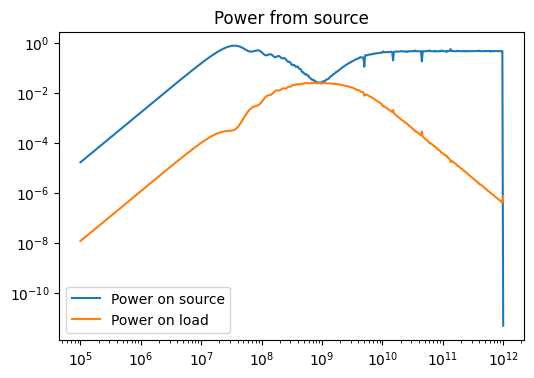

In [41]:
plt.figure(figsize=(6,4))

plt.title('Power from source')
plt.plot(np.geomspace(1e5, 1e12, 500), Pin, label='Power on source')
plt.plot(np.geomspace(1e5, 1e12, 500), PL, label='Power on load')

plt.xscale('log')
plt.yscale('log')

plt.legend()

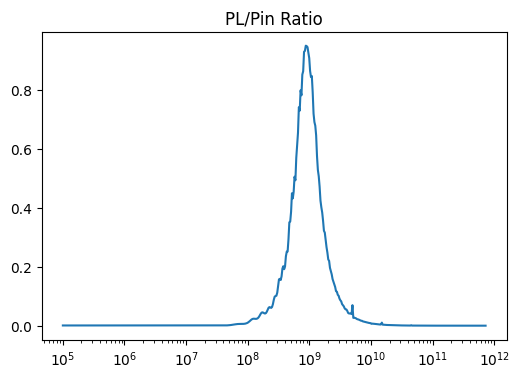

In [42]:
plt.figure(figsize=(6,4))

plt.title('PL/Pin Ratio')
plt.plot(np.geomspace(1e5, 1e12, 500)[:-10], np.array(PL/Pin)[:-10])

plt.xscale('log')

### Reframing in terms of complex sources 

There is another way to reframe this question: for a fixed $R_S$, $R_L$, and $L$, what is the optimal choice of C?

This is a slightly different way of thinking about this problem: we now suppose that we cannot vary $L$. This is equivalent to saying that we are attempting to match a complex source to a real-valued load. 

In [13]:
### FILL IN WITH CIRCUIT ANALYSIS: SHOW POWER DISSIPATED IN LOAD PEAKS AT RESONANT FREQUENCY

#Pout = V**2 / ()

We see that the matching of our network is fixed by the values of Rs and Rl. Now, let us evaluate the *power transfer* for this network to see whether it saturates the Bode-Fano bound. To do so, we consider the ratio of the power dissipated in the load to the total power delivered by the source. 

$$ P_{TOT} = \frac{V^2}{Z_{TOT}} $$

Now, obviously, we have selected our values of $L$ and $C$ to deliver maximum power on resonance because the network is perfectly impedance matched: $P_{TOT} = \frac{V^2}{2R_L}$. To look at the power consumed in the load, we do a voltage analysis on the circuit:



#### Brief Aside:

In the limit where $R_s < R_L$, this can also be identified as a low-pass network. In this limit, we can convert the parallel C and R to series as follows:

<img src="images/conversion.png" alt="Parallel to series conversion" width="300"/>

We can do this via the method of equalizing $Q$: $Q_{series} = Q_{parallel}$. To calculate the Q-value of the parallel RLC.....